In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from random import randint
import matplotlib.patches as mpatch
from matplotlib import colors as mcolors
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide

In [3]:
class Leaf:

    def __init__(self, x:int, y:int, label:str, priority:float=1):
        self._x = x
        self._y = y
        self._label = label
        self._priority = priority

    @property
    def x(self):
        return self._x

    @property
    def y(self):
        return self._y

    @property
    def label(self):
        return self._label

    @property
    def priority(self):
        return self._priority

    def __str__(self):
        return 'X: {} Y: {} Label: {}'.format(self._x, self._y, self._label, self._priority)


In [88]:
class QuadTree:

    def __init__(self, data: list, mins: tuple, maxs: tuple, depth: int
                 , divide_by: callable=None, metric_func: callable=None):
        self.data = data
        self.depth = depth

        self.metric_func = metric_func if callable(metric_func) else self._probability

        if mins is None:
            mins = (min(self.data, key=lambda x: x.x).x, min(self.data, key=lambda x: x.y).y)
        if maxs is None:
            maxs = (max(self.data, key=lambda x: x.x).x, max(self.data, key=lambda x: x.y).y)

        self.mins = np.asarray(mins)
        self.maxs = np.asarray(maxs)
        self.sizes = self.maxs - self.mins

        self.children = []

        mids = 0.5 * (self.mins + self.maxs)
        xmin, ymin = self.mins
        xmax, ymax = self.maxs
        xmid, ymid = mids

        divide = divide_by(self) if callable(divide_by) else depth > 0
        if divide:
            data_q1 = [leaf for leaf in data if (leaf.x < mids[0]) & (leaf.y < mids[1])]
            data_q2 = [leaf for leaf in data if (leaf.x < mids[0]) & (leaf.y >= mids[1])]
            data_q3 = [leaf for leaf in data if (leaf.x >= mids[0]) & (leaf.y < mids[1])]
            data_q4 = [leaf for leaf in data if (leaf.x >= mids[0]) & (leaf.y >= mids[1])]

            if len(data_q1) > 0:
                self.children.append(QuadTree(data_q1,
                                              [xmin, ymin], [xmid, ymid],
                                              depth - 1, divide_by=divide_by,
                                              metric_func=self.metric_func))
            if len(data_q2) > 0:
                self.children.append(QuadTree(data_q2,
                                              [xmin, ymid], [xmid, ymax],
                                              depth - 1, divide_by=divide_by,
                                              metric_func=self.metric_func))
            if len(data_q3) > 0:
                self.children.append(QuadTree(data_q3,
                                              [xmid, ymin], [xmax, ymid],
                                              depth - 1, divide_by=divide_by,
                                              metric_func=self.metric_func))
            if len(data_q4) > 0:
                self.children.append(QuadTree(data_q4,
                                              [xmid, ymid], [xmax, ymax],
                                              depth - 1, divide_by=divide_by,
                                              metric_func=self.metric_func))

    @property
    def metric(self):
        return self.metric_func(self)

    def _probability(self, o):
        priorities = [np.mean([d.priority for d in c.data]) for c in self.children]
        return [p/np.sum(priorities) for p in priorities]

    def draw_rectangle(self, ax, depth:int, prob:float=1, edgecolor='#000000'):
        """Recursively plot a visualization of the quad tree region"""
        if depth is None or depth == 0:

            rect = mpatch.Rectangle(self.mins, *self.sizes, zorder=2, ec=edgecolor, fc='none')
            rx, ry = rect.get_xy()
            cx = rx + rect.get_width() / 2.0
            cy = ry + rect.get_height() / 2.0
            ax.add_artist(rect)
            ax.annotate('{:1.2f}'.format(prob), (cx, cy), color='black', weight='bold',
                            fontsize=10, ha='center', va='center')

        if depth is None or depth > 0:
            color = 'black'# np.random.choice(list(mcolors.CSS4_COLORS), 1)[0]
            for child, prob in zip(self.children, self.metric):
                child.draw_rectangle(ax, depth - 1, prob, color)

    def __str__(self):
        return 'Min: {} Max: {} Size: {} Childs: {} '.format(self.mins, self.maxs, self.sizes, len(self.data))

In [8]:
path = Path('/data/Datasets/EIPH_WSI/')
database = Database()
database.open(str(path/'EIPH.sqlite'))
getslides = """SELECT uid, filename FROM Slides"""

currslide, filename = database.execute(getslides).fetchall()[0]

In [11]:
database.loadIntoMemory(currslide)

check = True if 'erliner' in filename else False
slidetype = 'Berliner Blau/' if check else 'Turnbull Blue/'

slide = openslide.open_slide(str(path / slidetype / filename))
level = slide.level_count - 1
level_dimension = slide.level_dimensions[level]
down_factor = slide.level_downsamples[level]

basepic = np.array(slide.read_region(location=(0, 0), level=level, size=level_dimension))
basepic = basepic[:, :, :3] # just rgb 

Loading DB into memory ...


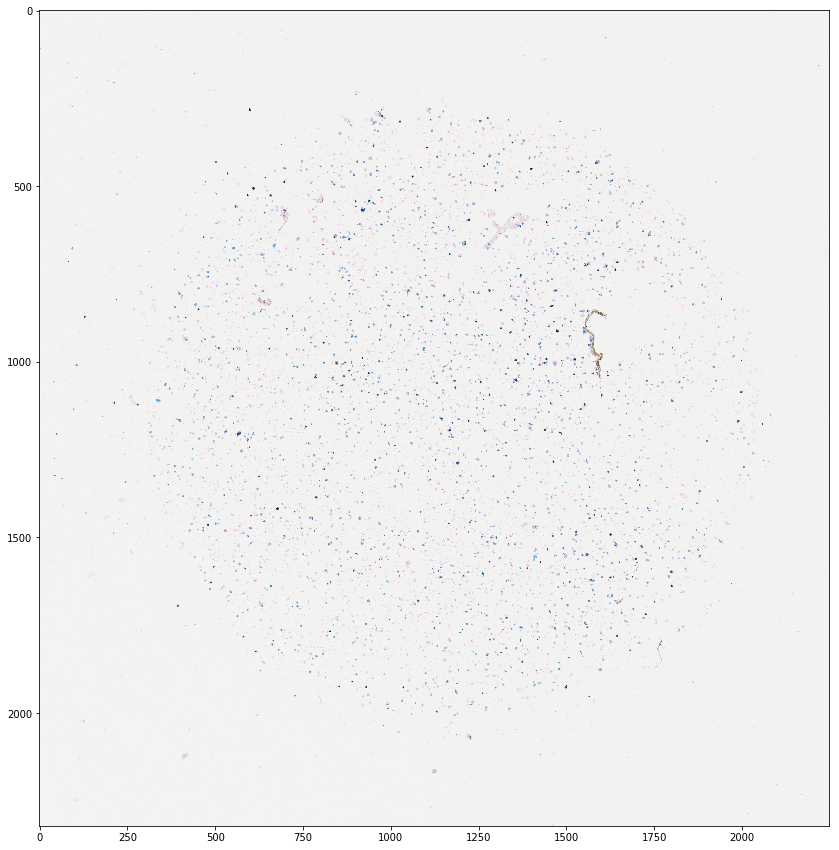

In [45]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(basepic)

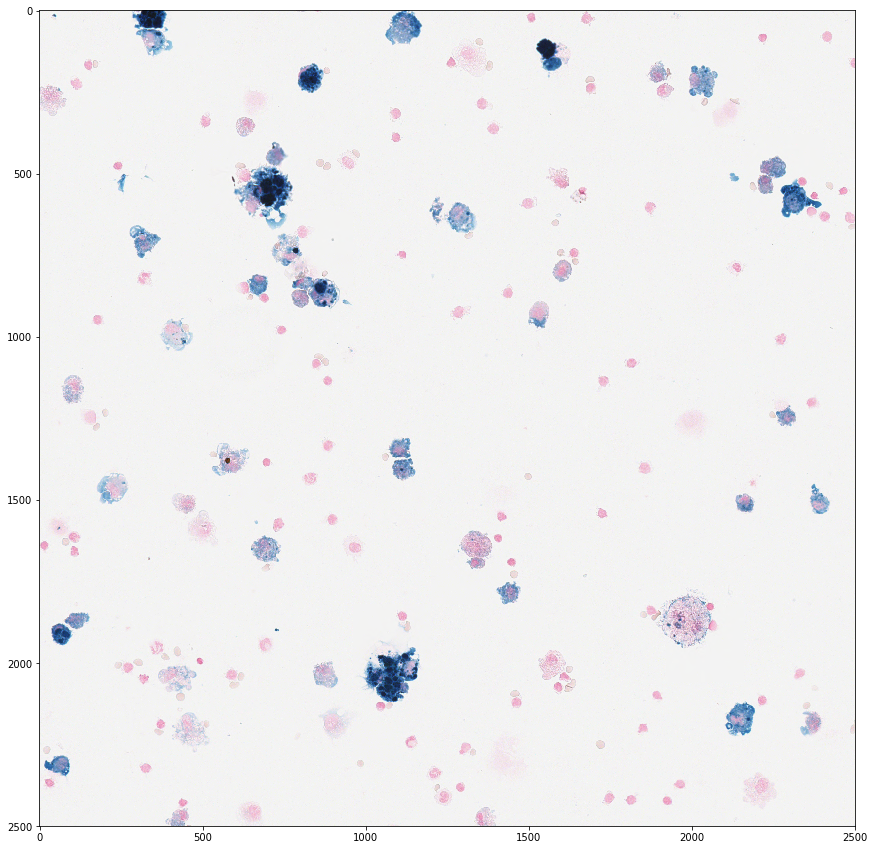

In [51]:
w,h = slide.level_dimensions[0]

sub_image = np.array(slide.read_region(location=(int(w / 2), int(h / 2)), level=0, size=(2500, 2500)))
sub_image = sub_image[:, :, :3] # just rgb 

fig = plt.figure(figsize=(15, 15))
plt.imshow(sub_image)

In [28]:
classes = {3: 0, 4: 1, 5: 2, 6: 3, 7: 4}
probability = [1, 1, 1, 1, 1]

In [35]:
data = []
for id, annotation in database.annotations.items():
    if annotation.labels[0].classId in classes:       
    
        d = int(2 * annotation.r / down_factor)
        x = int((annotation.x1 - annotation.r) / down_factor)
        y = int((annotation.y1 - annotation.r) / down_factor)
        label = classes[annotation.labels[0].classId]

        leaf =  Leaf(x,y,str(label), probability[label])
        data.append(leaf)

In [52]:
print('Cells: {}'.format(len(data)))
for key in classes:
    print('{}: {}'.format(classes[key], len([d.x for d in data if d.label == str(classes[key])])))

Cells: 4446
0: 1013
1: 1782
2: 1218
3: 348
4: 85


In [39]:
mins = (0,0)
maxs = basepic.shape[:2]

In [54]:
def divide_by_depth(o: QuadTree):
    return o.depth > 0

In [74]:
def divide_by_elements(o: QuadTree):
    return len(o.data) > 300

In [82]:
def count_metric(o: QuadTree):
    return [len(c.data) for c in o.children]

In [89]:
tree = QuadTree(data, mins, maxs, depth=3, divide_by=divide_by_depth, metric_func=count_metric)

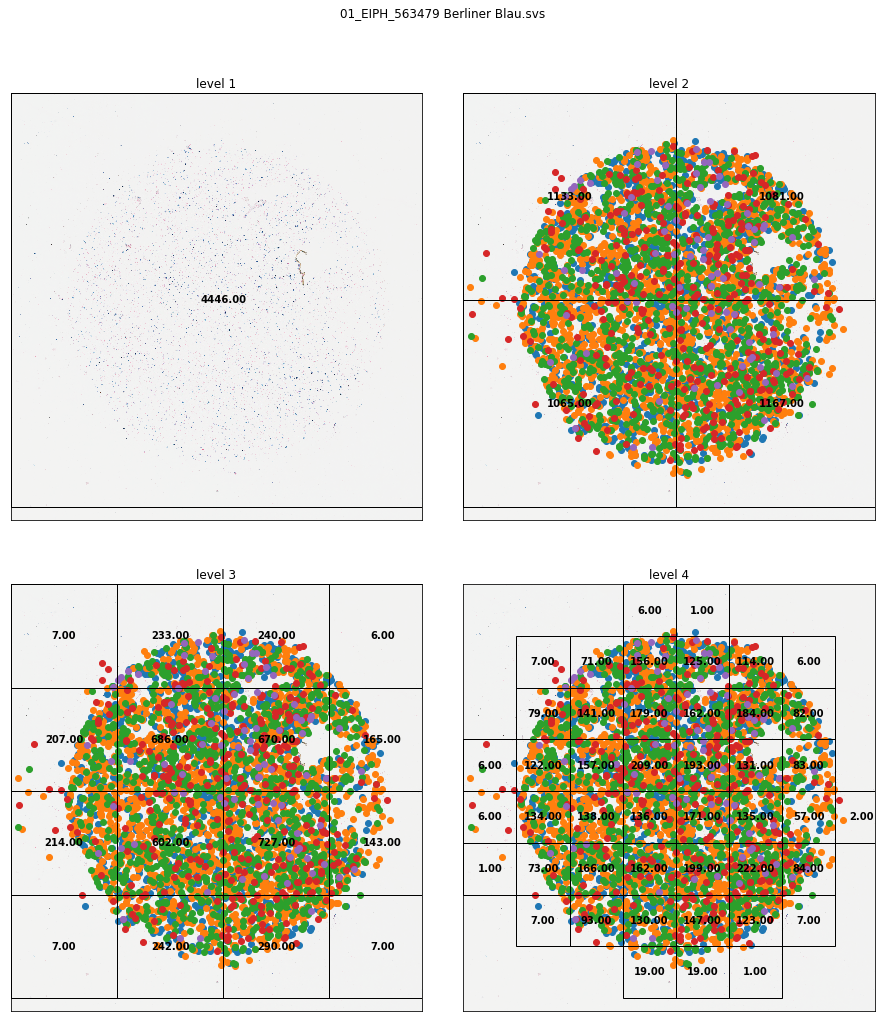

In [91]:
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(wspace=0.1, hspace=0.15,
                    left=0.1, right=0.9,
                    bottom=0.05, top=0.9)

for level in range(1, 5):
    ax = fig.add_subplot(2, 2, level, xticks=[], yticks=[])
    ax.imshow(basepic, aspect='auto')
    if level > 1:
        for key in classes:
            x = [d.x for d in data if d.label == str(classes[key])]
            y = [d.y for d in data if d.label == str(classes[key])]
            ax.scatter(x, y)
    tree.draw_rectangle(ax, depth=level - 1, prob=len(tree.data))
    ax.set_title('level %i' % level)

fig.suptitle('{}'.format(filename))
plt.show()